In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import os
import glob
import time
from sklearn.preprocessing import LabelBinarizer


def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding="SAME")
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, strides=2):
    return tf.nn.max_pool(x, ksize=[1, strides, strides, 1], strides=[1, strides, strides, 1], padding="SAME")


def conv_net(x, weights, biases, dropout, img_h=100, img_w=100, strides_pool=2, strides_conv=1, channels=3,
             conv_layers=[], no_max_pool=[]):
    x = tf.reshape(x, shape=[-1, img_h, img_w, channels])
    layers = {}
    conv_prev = x
    for li in conv_layers:
        conv_curr = conv2d(conv_prev, weights[li], biases[li], strides=strides_conv)
        if li not in no_max_pool:
            conv_curr = maxpool2d(conv_curr, strides=strides_pool)
        conv_prev = conv_curr
        layers[li] = conv_curr
    # here is the fully connected layer
    fullyconnected = tf.reshape(conv_prev, [-1, weights['wfc'].get_shape().as_list()[0]])
    fullyconnected = tf.add(tf.matmul(fullyconnected, weights['wfc']), biases['wfc'])
    fullyconnected = tf.nn.relu(fullyconnected)
    # dropout
    fullyconnected = tf.nn.dropout(fullyconnected, dropout)
    # output
    out = tf.add(tf.matmul(fullyconnected, weights['wout']), biases['bout'])
    return out


def get_img_cv2(path):
    img = cv2.imread(path)
    return img


def load_set(base_path, trainset=True):
    X_train = []
    X_train_id = []
    y_train = []
    orig_image = []
    start_time = time.time()
    setpath = None
    if trainset:
        setpath = 'Training'
    else:
        setpath = 'Validation'
    base = os.path.join(base_path, setpath)
    print("start loading images - basepath: {}".format(base))
    for root, dirs, files in os.walk(base):
        for cat in dirs:
            curr_index = dirs.index(cat)
            category_path = os.path.join(base, cat, "*.jpg")
            files = glob.glob(category_path)
            for file in files:
                fname = os.path.basename(file)
                image = get_img_cv2(file)
                X_train.append(image)
                orig_image.append(image)
                X_train_id.append(fname)
                y_train.append(curr_index)
    print("Load images complete - total time {0:.2f} sec".format((time.time() - start_time)))
    return X_train, X_train_id, y_train, orig_image

def normalize_set(dataset=[], target=[], dataset_id=[]):
    print("convert to numpy array...")
    dataset = np.array(dataset, dtype=np.uint8)
    target = np.array(target, dtype=np.uint8)
    print("dataset shape {}".format(dataset.shape))
    print("Reshape...")
    dataset = dataset.transpose((0, 2, 3, 1))
    dataset = dataset.transpose((0, 1, 3, 2))
    print("new dataset shape {}".format(dataset.shape))
    print("Convert to float...")
    dataset = dataset.astype(np.float32)
    dataset = dataset / 255
    target = LabelBinarizer().fit_transform(target)
    print("new target shape {}".format(target.shape))
    return dataset, dataset_id, target

def generate_cat_mapping(base_path):
    y_mapping = {}
    start_time = time.time()
    setpath = 'Training'
    base = os.path.join(base_path, setpath)
    print("start generating category mapping for dataset: {}".format(base))
    for root, dirs, files in os.walk(base):
        for cat in dirs:
            curr_index = dirs.index(cat)
            y_mapping[curr_index] = cat
    print("Category mapping complete - total time {0:.2f} sec".format((time.time() - start_time)))
    return y_mapping

In [3]:
use_trainset = False

In [4]:
X_test, X_test_id, y_test, orig_image_test = load_set("./fruits-360", trainset=use_trainset)

start loading images - basepath: ./fruits-360/Validation
Load images complete - total time 2.92 sec


In [5]:
X_test, X_test_id, y_test = normalize_set(X_test, y_test, X_test_id)

convert to numpy array...
dataset shape (9673, 100, 100, 3)
Reshape...
new dataset shape (9673, 100, 100, 3)
Convert to float...
new target shape (9673, 60)


In [6]:
n_images = 28736
learning_rate = 0.01
epochs = 30
batch_size = 300
num_batches = int(n_images / batch_size)
in_h = 100
in_w = 100
n_classes = 60
dropout = 0.6
display_step = 1
filter_h = 3
filter_w = 3
fully_connected_layer = 2048
depth_in = 3 #rgb channels
depth_out1 = 32
depth_out2 = 64
depth_out3 = 64

In [7]:
#input and oputput layers definition
x = tf.placeholder(dtype=tf.float32, shape=[None, in_h, in_w, depth_in])
y = tf.placeholder(dtype=tf.float32, shape=[None, n_classes])
keep_prob = tf.placeholder(dtype=tf.float32)

In [8]:
#weights of the layers
weights = {
    "wc1": tf.Variable(tf.random_normal([filter_h, filter_w, depth_in, depth_out1])),
    "wc1a": tf.Variable(tf.random_normal([filter_h, filter_w, depth_out1, depth_out1])),
    "wc2": tf.Variable(tf.random_normal([filter_h, filter_w, depth_out1, depth_out2])),
    "wc3": tf.Variable(tf.random_normal([filter_h, filter_w, depth_out2, depth_out3])),
    "wfc": tf.Variable(tf.random_normal([tf.cast((in_h/4) * (in_w/4) * depth_out3, tf.int32), fully_connected_layer])),
    "wout": tf.Variable(tf.random_normal([fully_connected_layer, n_classes]))
}

In [9]:
#biases
biases = {
    "wc1": tf.Variable(tf.random_normal([depth_out1])),
    "wc1a": tf.Variable(tf.random_normal([depth_out1])),
    "wc2": tf.Variable(tf.random_normal([depth_out2])),
    "wc3": tf.Variable(tf.random_normal([depth_out3])),
    "wfc": tf.Variable(tf.random_normal([fully_connected_layer])),
    "bout": tf.Variable(tf.random_normal([n_classes]))
}

In [10]:
pred = conv_net(x, weights, biases, keep_prob, in_h, in_w, strides_pool=2, strides_conv=1, channels=3, conv_layers=['wc1', 'wc1a', 'wc2', 'wc3'], no_max_pool=['wc1', 'wc2'])
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [11]:
init = tf.global_variables_initializer()
start_time = time.time()
saver = tf.train.Saver()
test_classes = np.empty(0)
with tf.Session() as sess:
    print("restoring model...")
    saver.restore(sess, "/dev/shm/model-fruits-cnn.ckpt")
    for j in range(int(X_test.shape[0] / 300)):
        print("[{}] predicting...".format((j+1)))
        y1 = sess.run(pred, feed_dict={x: X_test[j*300:(j+1)*300,:,:,:], keep_prob: 1.})
        test_classes = np.append(test_classes, np.argmax(y1, 1))
    if (j+1)*300 < X_test.shape[0]:
        print("[{}] predicting...".format((j+1)))
        y1 = sess.run(pred, feed_dict={x: X_test[(j+1)*300:,:,:,:], keep_prob: 1.})
        test_classes = np.append(test_classes, np.argmax(y1, 1))
test_accuracy = np.mean(np.equal(test_classes, np.argmax(y_test, 1)).astype(np.float32))
print("({:.2f}sec) Testset accuracy: {}".format((time.time() - start_time), test_accuracy))

restoring model...
INFO:tensorflow:Restoring parameters from /dev/shm/model-fruits-cnn.ckpt
[1] predicting...
[2] predicting...
[3] predicting...
[4] predicting...
[5] predicting...
[6] predicting...
[7] predicting...
[8] predicting...
[9] predicting...
[10] predicting...
[11] predicting...
[12] predicting...
[13] predicting...
[14] predicting...
[15] predicting...
[16] predicting...
[17] predicting...
[18] predicting...
[19] predicting...
[20] predicting...
[21] predicting...
[22] predicting...
[23] predicting...
[24] predicting...
[25] predicting...
[26] predicting...
[27] predicting...
[28] predicting...
[29] predicting...
[30] predicting...
[31] predicting...
[32] predicting...
[32] predicting...
(8.50sec) Testset accuracy: 0.9649540185928345


In [12]:
actual_test_classes = np.argmax(y_test, 1)

In [13]:
cats_map = generate_cat_mapping("./fruits-360")

start generating category mapping for dataset: ./fruits-360/Training
Category mapping complete - total time 0.04 sec


(0) predicted class: Tangelo, actual: Tangelo
(100) predicted class: Tangelo, actual: Tangelo
(500) predicted class: Apricot, actual: Apricot
(1000) predicted class: Maracuja, actual: Maracuja
(1400) predicted class: Pear Abate, actual: Peach Flat
(2000) predicted class: Apple Red Delicious, actual: Apple Red Delicious
(2400) predicted class: Apple Red 3, actual: Apple Red 3


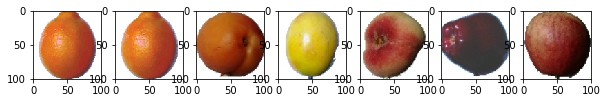

In [14]:
f, a = plt.subplots(1, 7, figsize=(10, 20))

a[0].imshow(orig_image_test[0][:,:,[2, 1, 0]])
print("(0) predicted class: {}, actual: {}".format(cats_map[test_classes[0]], cats_map[actual_test_classes[0]]))
a[1].imshow(orig_image_test[100][:,:,[2, 1, 0]])
print("(100) predicted class: {}, actual: {}".format(cats_map[test_classes[100]], cats_map[actual_test_classes[100]]))
a[2].imshow(orig_image_test[500][:,:,[2, 1, 0]])
print("(500) predicted class: {}, actual: {}".format(cats_map[test_classes[500]], cats_map[actual_test_classes[500]]))
a[3].imshow(orig_image_test[1000][:,:,[2, 1, 0]])
print("(1000) predicted class: {}, actual: {}".format(cats_map[test_classes[1000]], cats_map[actual_test_classes[1000]]))
a[4].imshow(orig_image_test[1400][:,:,[2, 1, 0]])
print("(1400) predicted class: {}, actual: {}".format(cats_map[test_classes[1400]], cats_map[actual_test_classes[1400]]))
a[5].imshow(orig_image_test[2000][:,:,[2, 1, 0]])
print("(2000) predicted class: {}, actual: {}".format(cats_map[test_classes[2000]], cats_map[actual_test_classes[2000]]))
a[6].imshow(orig_image_test[2400][:,:,[2, 1, 0]])
print("(2400) predicted class: {}, actual: {}".format(cats_map[test_classes[2400]], cats_map[actual_test_classes[2400]]))